In [1]:
import numpy as np
import os

from matplotlib import pyplot as plt 

from steves_utils.stratified_dataset.episodic_accessor import Episodic_Accessor_Factory

from steves_utils.utils_v2 import get_datasets_base_path

from steves_utils.transforms import get_chained_transform

In [2]:
import steves_utils.wisig.utils as wisig

from steves_utils.ORACLE.utils_v2 import (
    ALL_DISTANCES_FEET_NARROWED,
    ALL_RUNS,
    ALL_SERIAL_NUMBERS,
)

from steves_utils.CORES.utils import (
    ALL_NODES,
    ALL_NODES_MINIMUM_1000_EXAMPLES,
    ALL_DAYS
)

In [3]:
SEED = 1337
N    = 20

In [4]:
"""
Get every example from the train dataset, coalesce them, and randomly pick N
This uses the same exact dataset pipeline as the experiments.

This is overkill, but I want to be thorough
"""
def get_examples(
    pickle_path:str,
    labels,
    domains,
    x_transforms=None,
)->tuple:
    if x_transforms == None:
        x_transform_func = None
    else:
        x_transform_func = get_chained_transform(x_transforms)
    eaf = Episodic_Accessor_Factory(
        labels=labels,
        domains=domains,
        num_examples_per_domain_per_label=-1,
        iterator_seed=SEED,
        dataset_seed=SEED,
        n_shot=3,
        n_way=16,
        n_query=3,
        train_val_test_k_factors=(1,1,1),
        pickle_path=pickle_path,
        x_transform_func=x_transform_func,
    )

    t = eaf.get_train()

    ex = []
    
    for u, (s_x, s_y, q_x, q_y, ground) in t:
        s_y_real = np.array(ground)[s_y]
        q_y_real = np.array(ground)[s_y]
        
        for x, y in zip(s_x, s_y):
            ex.append((x.numpy(),int(y.numpy()),u))
        for x, y in zip(q_x, q_y):
            ex.append((x.numpy(),int(y.numpy()),u))

    idxs = np.random.default_rng(SEED).choice(len(ex), size=N, replace=False)

    out = [ex[i] for i in idxs]
    
    return out

In [5]:
def do_time_plot(dataset, example, ax):
    ax.set_title(f"{dataset} y={example[1]} u={example[2]}")   
    x = example[0]    
    x = x[0] + 1.0j*x[1]

    ax.plot(range(len(x)),np.abs(x))
    
    plt.xlabel("t")
    plt.ylabel("magnitude")

def do_frequency_plot(dataset, example, ax):
    ax.set_title(f"{dataset} y={example[1]} u={example[2]}")   
    x = example[0]
    x = x[0] + 1.0j*x[1]
    f = 25e6
    signal_spectrum = np.fft.fftshift(np.fft.fft(x))
    freqs = np.fft.fftshift(np.fft.fftfreq(len(x), d=1.0/f))
    ax.plot(freqs / 1e6, np.abs(signal_spectrum))  # in MHz
    
    plt.xlabel("freq(MHz)")
    plt.ylabel("magnitude")

In [6]:
oracle_orig = get_examples(
    pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl"),
    labels=ALL_SERIAL_NUMBERS,
    domains=ALL_DISTANCES_FEET_NARROWED,
)

cores_orig = get_examples(
    pickle_path=os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
    labels=ALL_NODES,
    domains=ALL_DAYS,
)

wisig_orig = get_examples(
    pickle_path=os.path.join(get_datasets_base_path(), "wisig.node3-19.stratified_ds.2022A.pkl"),
    labels=wisig.ALL_NODES_MINIMUM_100_EXAMPLES,
    domains=wisig.ALL_DAYS,
)

In [7]:
oracle_resamp = get_examples(
    pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl"),
    labels=ALL_SERIAL_NUMBERS,
    domains=ALL_DISTANCES_FEET_NARROWED,
    x_transforms = ["take_200", "resample_20Msps_to_25Msps"]
)

cores_resamp = get_examples(
    pickle_path=os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
    labels=ALL_NODES,
    domains=ALL_DAYS,
    x_transforms = ["take_200"]
)

wisig_resamp = get_examples(
    pickle_path=os.path.join(get_datasets_base_path(), "wisig.node3-19.stratified_ds.2022A.pkl"),
    labels=wisig.ALL_NODES_MINIMUM_100_EXAMPLES,
    domains=wisig.ALL_DAYS,
    x_transforms = ["take_200"]
)

In [8]:
oracle_filter = oracle_resamp # oracle does not get resampled

cores_filter = get_examples(
    pickle_path=os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
    labels=ALL_NODES,
    domains=ALL_DAYS,
    x_transforms = ["lowpass_+/-10MHz", "take_200"]
)

wisig_filter = get_examples(
    pickle_path=os.path.join(get_datasets_base_path(), "wisig.node3-19.stratified_ds.2022A.pkl"),
    labels=wisig.ALL_NODES_MINIMUM_100_EXAMPLES,
    domains=wisig.ALL_DAYS,
    x_transforms = ["lowpass_+/-10MHz", "take_200"]
)

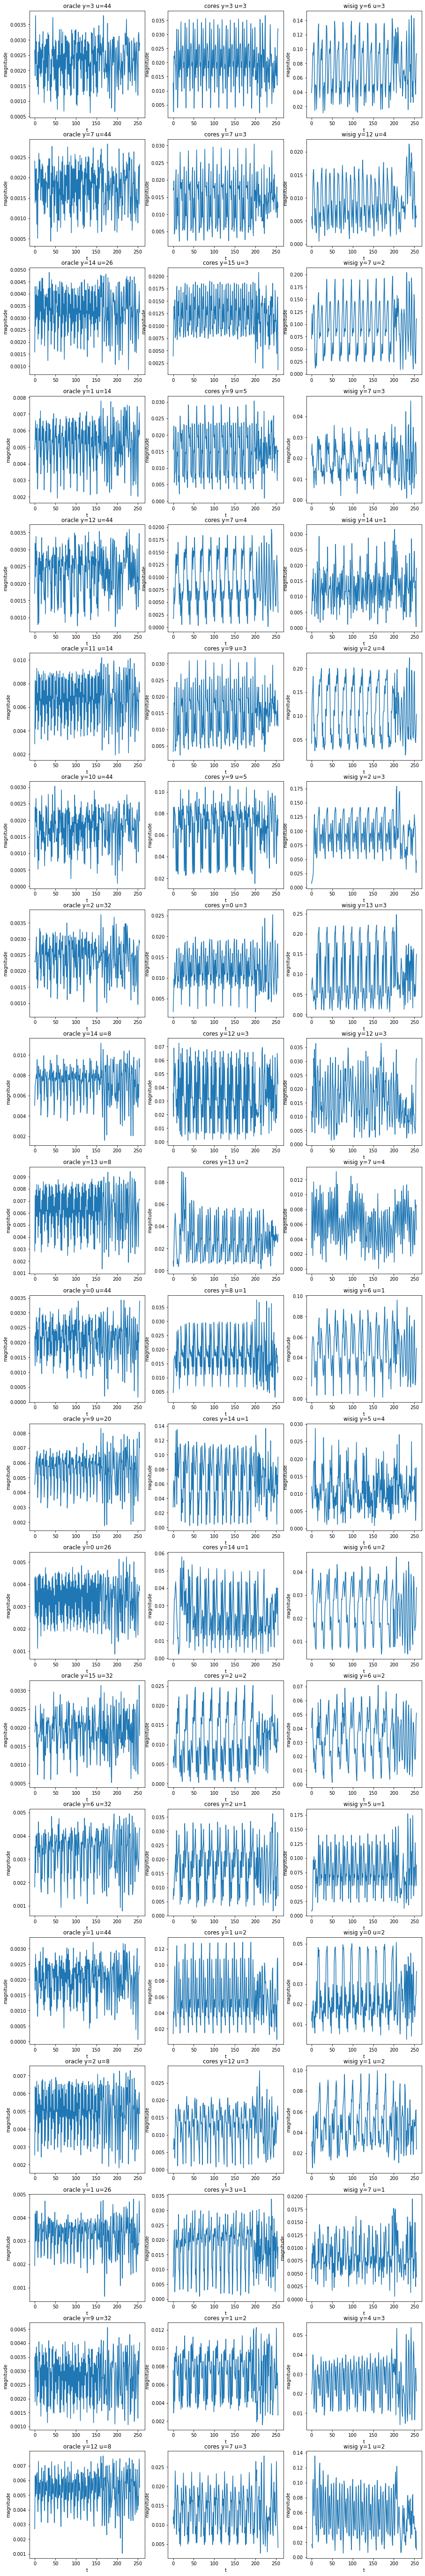

In [9]:
plt.figure(figsize=(15,100))

for i, ex in enumerate(oracle_orig):
    ax = plt.subplot(N,3,i*3+1)
    do_time_plot("oracle", ex, ax)
for i, ex in enumerate(cores_orig):
    ax = plt.subplot(N,3,i*3+2)
    do_time_plot("cores", ex, ax)
for i, ex in enumerate(wisig_orig):
    ax = plt.subplot(N,3,i*3+3)
    do_time_plot("wisig", ex, ax)

We can see in the above that oracle and cores/wisig are fairly divergent.  
In addition, we can see that the training sequence (the periodic beginning portion of the signal is a different length between oracle and cores/wisig.  
  
Finally, we see that cores/wisig has some extra noise at the end of the training sequence (this is expected).  
  
To mitigate these difference, we upsample ORACLE to 25Msps (the same as cores/wisig) and then we clip all signals to 200 samples (this is the expected length of the training sequence at 25Msps).

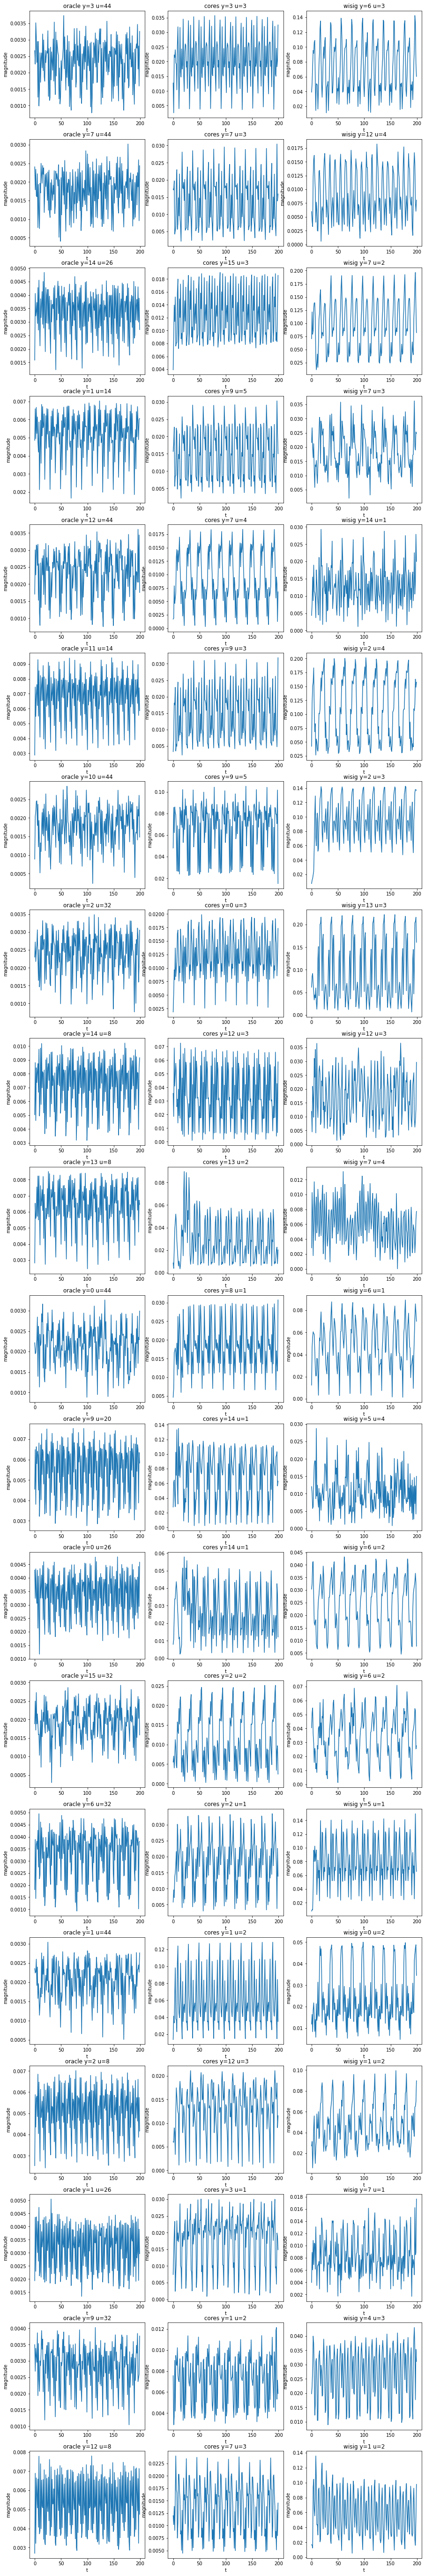

In [10]:
plt.figure(figsize=(15,100))

for i, ex in enumerate(oracle_resamp):
    ax = plt.subplot(N,3,i*3+1)
    do_time_plot("oracle", ex, ax)
for i, ex in enumerate(cores_resamp):
    ax = plt.subplot(N,3,i*3+2)
    do_time_plot("cores", ex, ax)
for i, ex in enumerate(wisig_resamp):
    ax = plt.subplot(N,3,i*3+3)
    do_time_plot("wisig", ex, ax)

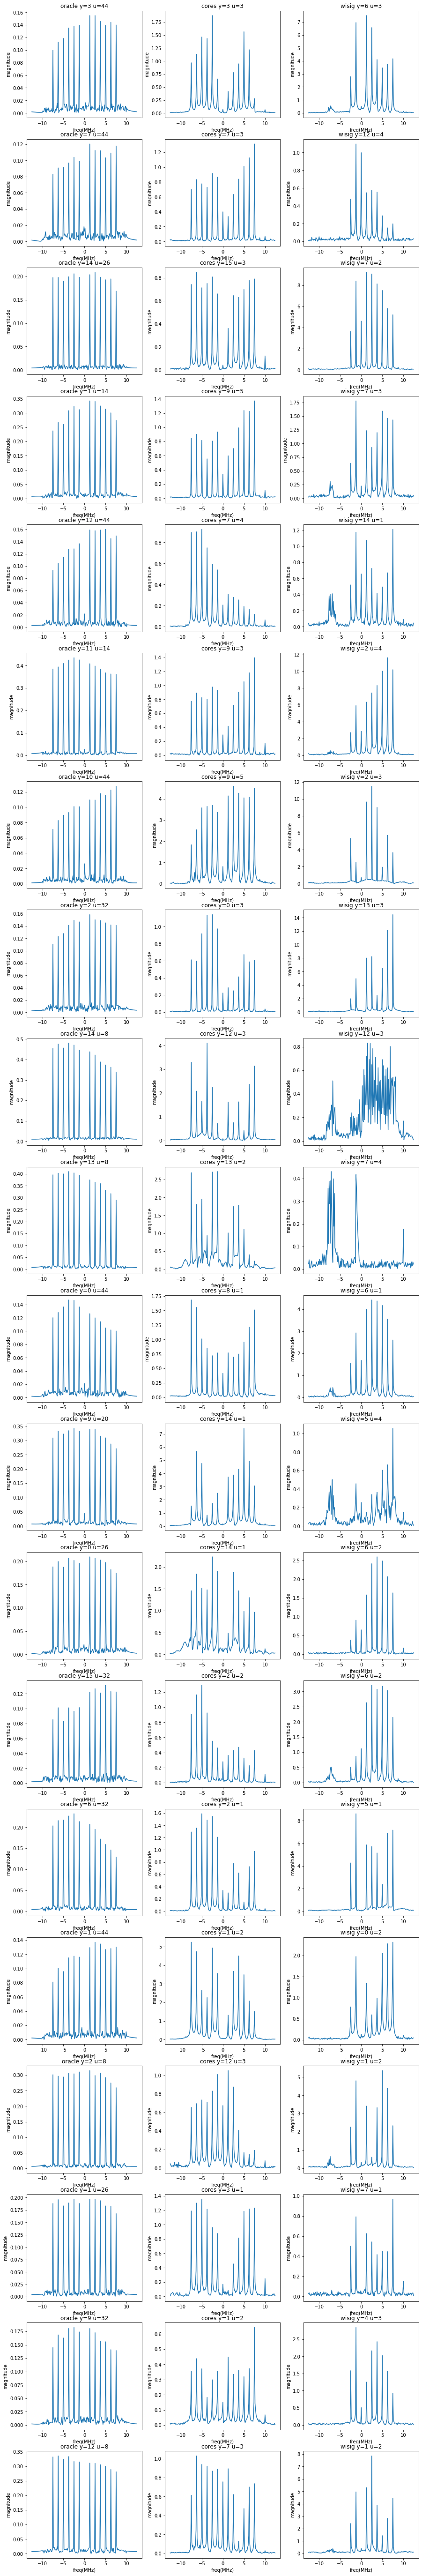

In [11]:
plt.figure(figsize=(15,100))

for i, ex in enumerate(oracle_resamp):
    ax = plt.subplot(N,3,i*3+1)
    do_frequency_plot("oracle", ex, ax)
for i, ex in enumerate(cores_resamp):
    ax = plt.subplot(N,3,i*3+2)
    do_frequency_plot("cores", ex, ax)
for i, ex in enumerate(wisig_resamp):
    ax = plt.subplot(N,3,i*3+3)
    do_frequency_plot("wisig", ex, ax)

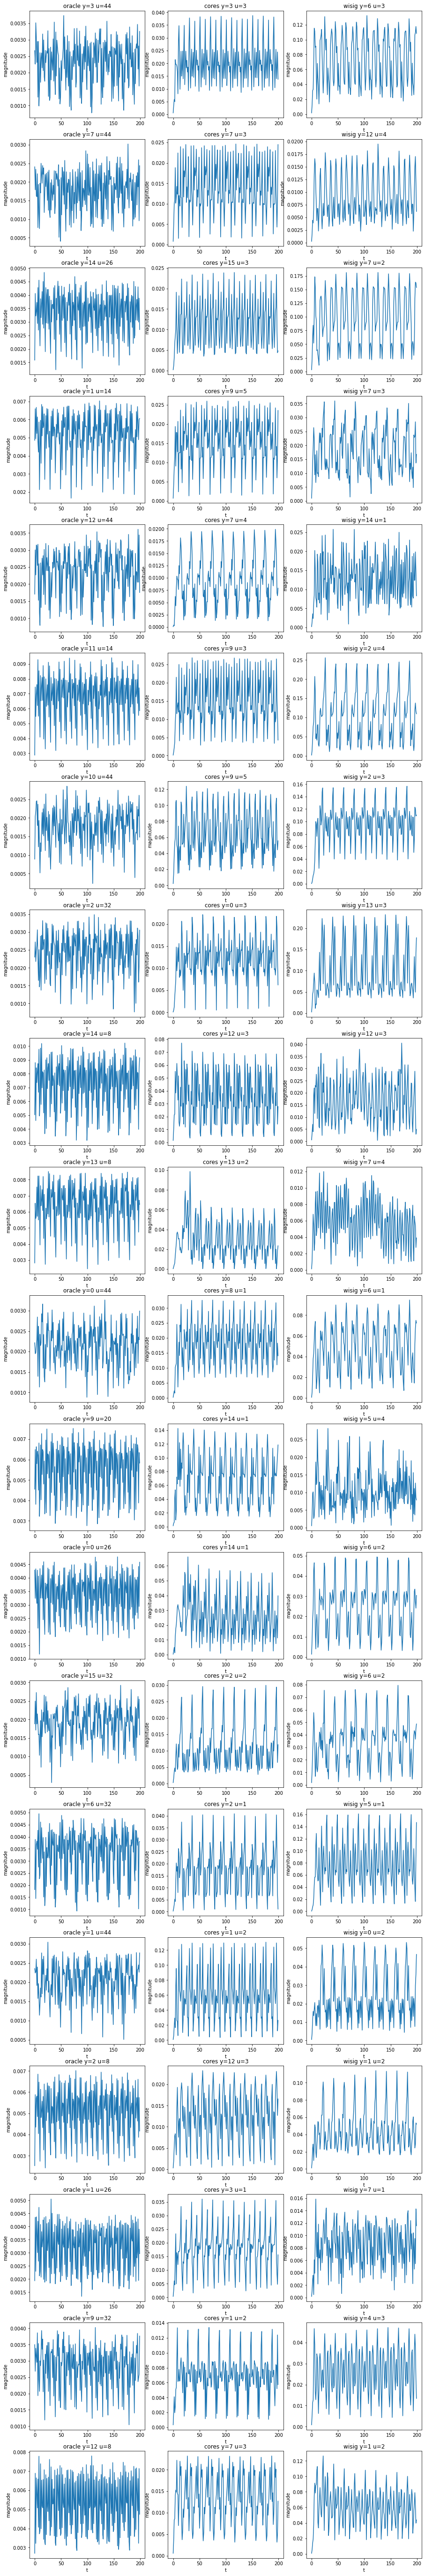

In [14]:
plt.figure(figsize=(15,100))

for i, ex in enumerate(oracle_filter):
    ax = plt.subplot(N,3,i*3+1)
    do_time_plot("oracle", ex, ax)
for i, ex in enumerate(cores_filter):
    ax = plt.subplot(N,3,i*3+2)
    do_time_plot("cores", ex, ax)
for i, ex in enumerate(wisig_filter):
    ax = plt.subplot(N,3,i*3+3)
    do_time_plot("wisig", ex, ax)

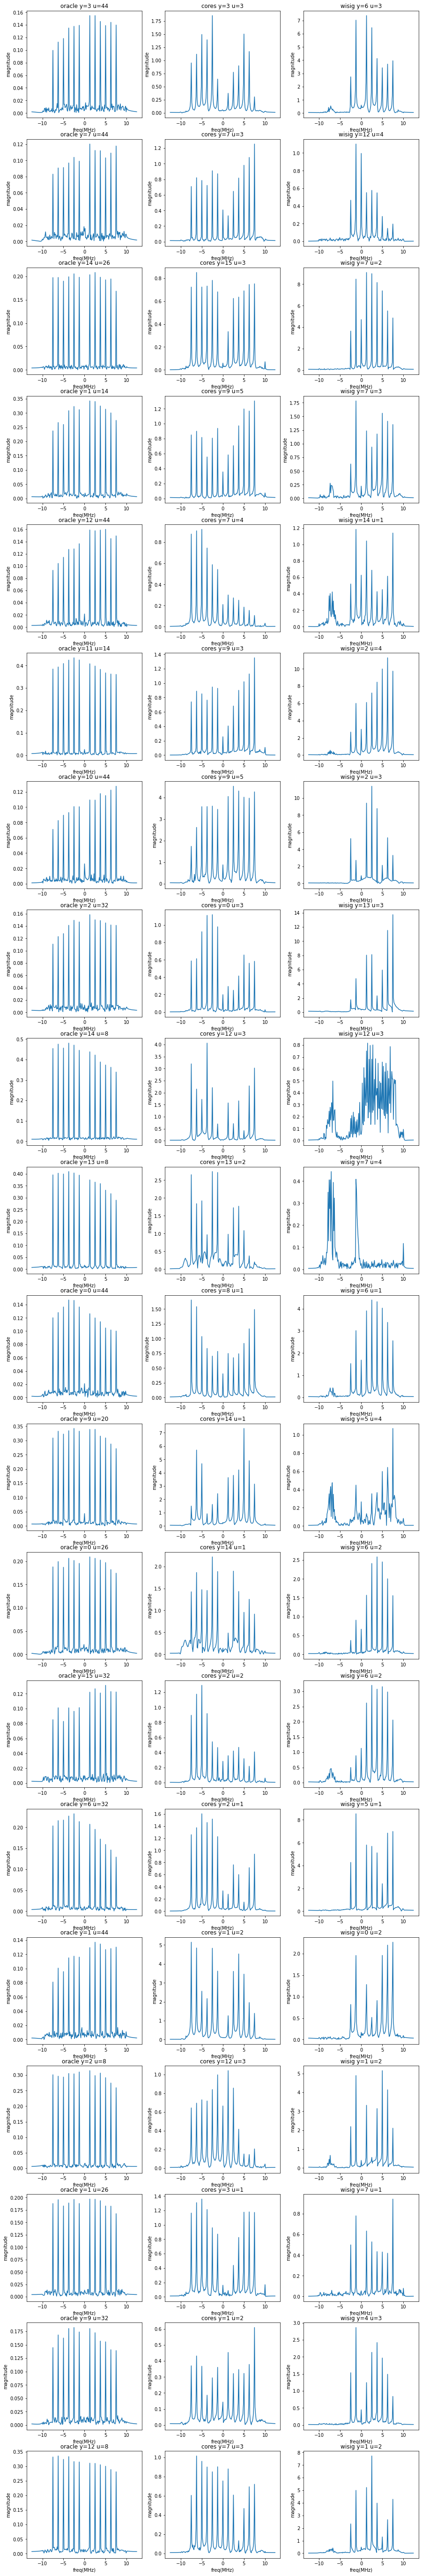

In [12]:
plt.figure(figsize=(15,100))

for i, ex in enumerate(oracle_filter):
    ax = plt.subplot(N,3,i*3+1)
    do_frequency_plot("oracle", ex, ax)
for i, ex in enumerate(cores_filter):
    ax = plt.subplot(N,3,i*3+2)
    do_frequency_plot("cores", ex, ax)
for i, ex in enumerate(wisig_filter):
    ax = plt.subplot(N,3,i*3+3)
    do_frequency_plot("wisig", ex, ax)

In [13]:
import sys
sys.exit(1)


SystemExit: 1

/mnt/wd500GB/CSC500/csc500-main/venv/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3465: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


ORACLE is sampled at 5Msps, the rest are at 25Msps

In [ ]:
# Stolen from https://stackoverflow.com/questions/2598734/numpy-creating-a-complex-array-from-2-real-ones
# oracle_x = np.apply_along_axis(lambda args: [complex(*args)], 1, oracle_x.T).flatten()
oracle_x = oracle_x[0] + oracle_x[1]*1j

cores_x = np.apply_along_axis(lambda args: [complex(*args)], 1, cores_x.T).flatten()

# oracle_x = oracle_x[:160]
# cores_x  = cores_x[:200]

In [ ]:
plt.figure(figsize=(15,5))
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)
ax1.set_title("ORACLE Time Domain")
ax2.set_title("CORES Time Domain")

ax1.plot(range(len(oracle_x)),np.abs(oracle_x))
ax2.plot(range(len(cores_x)),np.abs(cores_x))

In [ ]:
plt.figure(figsize=(15,5))
# ORACLE
f = 25e6
signal_spectrum = np.fft.fftshift(np.fft.fft(oracle_x))
freqs = np.fft.fftshift(np.fft.fftfreq(len(oracle_x), d=1.0/f))
ax1 = plt.subplot(1,2,1)
ax1.set_title("ORACLE Frequency Domain")
ax1.plot(freqs / 1e6, np.abs(signal_spectrum))  # in MHz

# CORES
f = 25e6
signal_spectrum = np.fft.fftshift(np.fft.fft(cores_x))
freqs = np.fft.fftshift(np.fft.fftfreq(len(cores_x), d=1.0/f))
ax2 = plt.subplot(1,2,2)
ax2.set_title("CORES Frequency Domain")
ax2.plot(freqs / 1e6, np.abs(signal_spectrum))  # in MHz


# ax2 = plt.subplot(1,2,2)
# ax2.set_title("CORES Time Domain")

# ax2.plot(range(len(cores_x)),np.abs(cores_x))

In [ ]:
# Upsample and clip oracle
from scipy import signal

original_sample_rate = 20e6
target_sample_rate = 25e6

oracle_x_prime = signal.resample(oracle_x, int(len(oracle_x)*target_sample_rate/original_sample_rate))
oracle_x_prime = oracle_x_prime[:200]

In [ ]:
# Taken from https://stackoverflow.com/questions/25191620/creating-lowpass-filter-in-scipy-understanding-methods-and-units
import numpy as np
from scipy.signal import butter, lfilter, freqz
import matplotlib.pyplot as plt



def build_butter_filter(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def apply_filter(b,a,x):
    y = lfilter(b, a, x)
    return y

# Filter requirements.
order = 15
fs = 25e6       # sample rate, Hz
cutoff = 10e6  # desired cutoff frequency of the filter, Hz

# Get the filter coefficients so we can check its frequency response.
b, a = build_butter_filter(cutoff, fs, order)


cores_x_prime = apply_filter(b, a, cores_x)
# cores_x_prime = cores_x

In [ ]:
plt.figure(figsize=(15,5))
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)
ax1.set_title("ORACLE Prime Time Domain")
ax2.set_title("CORES Prime Time Domain")

ax1.plot(range(len(oracle_x_prime)),np.abs(oracle_x_prime))
ax2.plot(range(len(cores_x_prime)),np.abs(cores_x_prime))

In [ ]:
plt.figure(figsize=(15,5))
# ORACLE
f = 25e6
signal_spectrum = np.fft.fftshift(np.fft.fft(oracle_x_prime))
freqs = np.fft.fftshift(np.fft.fftfreq(len(oracle_x_prime), d=1.0/f))
ax1 = plt.subplot(1,2,1)
ax1.set_title("ORACLE Prime Frequency Domain")
ax1.plot(freqs / 1e6, np.abs(signal_spectrum))  # in MHz

# CORES
f = 25e6
signal_spectrum = np.fft.fftshift(np.fft.fft(cores_x_prime))
freqs = np.fft.fftshift(np.fft.fftfreq(len(cores_x_prime), d=1.0/f))
ax2 = plt.subplot(1,2,2)
ax2.set_title("CORES Prime Frequency Domain")
ax2.plot(freqs / 1e6, np.abs(signal_spectrum))  # in MHz